In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 2
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 0,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 0
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model.to(device)
# set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, o

# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragonfly in a fairy tale. I have never seen a dragonfly so beautiful. I'm not even sure if it's a dragonfly or a fairy. I've never even seen a dragonfly.

I am a dragonfly in a fairy tale. I have never seen a dragonfly so beautiful. I'm not even sure if it's a dragonfly or a fairy. I've never seen a dragonfly.

My friend, her name is Linda, I have never seen a dragonfly so beautiful. I'm a dragonfly in a fairy tale. I have never seen a


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
print("Dataset demo snapshot:")
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))
    break

print("RP review!")
has_seen_rp = False
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    if 'c "Fight ' in decoded: 
        print(decoded)
        has_seen_rp = True
        continue        
    if has_seen_rp:
        print(decoded)
        break
# Clean up
del has_seen_rp
# dataset['model_seeder'].stop_worker()
# del dataset

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors


<p><msg>c "He hasn't used the portal yet, though."<d><scn>np1r<msg>Br "How could he? Isn't it broken?"<|endoftext|><p><msg>c "Sure."<|endoftext|><p><msg>c "I could fetch it after we're done with this."<|endoftext|><p><msg>c "..."<d><scn>o2<msg>Br "Do you think it's easy for me? Seeing so many people die on my watch?"<d><scn>o2<msg>Br "Do you think I don't
RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors


 here before?"<p><msg>c "Once or twice."<|endoftext|><p><msg>c "Don't forget what I said earlier about what I expect from you on this date. You better be on your best behavior."<|endoftext|><p><msg>c "Fight Remy"<d><scn>park2<msg>m "Remy dodges my attack and comes rushing towards me"<|endoftext|><d><scn>facin2<msg>An "Some might even say "<|endoftext|><d><scn>o2<msg>m "It was interesting that they still relied on me for their
 investigations, even after they tried to send me back to my world. I didn't expect them to allow me to help with police matters after everything that had happened."<|endoftext|><p><msg>c "It's always about work with you. Come on, you're on break. Maybe we should do something to take your mind off of all that for once."<d><scn>cafe<msg>An "Like what?"<|endoftext|><p><msg>c "This should do the trick."<|endoftext|><d><scn>black<msg>Ry "A while."<|endoftext|><d><scn>facin


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
2,4.107700
4,3.519200
6,2.732300
8,2.455800
10,2.287300
12,2.158000
14,2.117200
16,1.981000
18,1.863600
20,1.867300


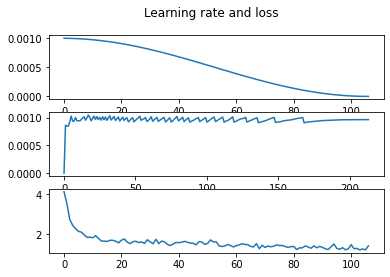

In [9]:
fig, axs = plt.subplots(3)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['model_closeness_loss'])
axs[2].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

# Conversion to ONNX
ONNX is a different format for running machine learning models. The ONNX format is much faster on CPU, sometimes 5 times as fast as PyTorch!

While the EAWSW model is designed to be small, accurate and accessible, for some people it's still too much to run...

Hosting the model as a free service for players is an option. An ONNX version of the model allows us to host the model on CPU yet have faster response times! Given that the model is made in a time with chip shortage, running on hardware I already have inside a server is efficient, scalable and cheaper.

An important note is that ONNX doesn't execute logic by itself, and you have to do that yourself, `onnx_model_manager.py` intends to deal with this for us.

In [11]:
saved_model_onnx_path = os.path.join("models", "awsw_onnx")
if not os.path.exists(os.path.join(saved_model_path, "special_tokens_map.json")):
    print("Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!")
    !cd $saved_model_path && git clone https://huggingface.co/EleutherAI/gpt-neo-125M
    !cp -n $saved_model_path/gpt-neo-125M/* $saved_model_path
    !rm -rf $saved_model_path/gpt-neo-125M
if not os.path.exists(os.path.join(saved_model_onnx_path, "model.onnx")):
    !python3 -m transformers.onnx --model=$saved_model_path --feature=causal-lm-with-past $saved_model_onnx_path

Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!
Cloning into 'gpt-neo-125M'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 38 (delta 16), reused 0 (delta 0)
Unpacking objects: 100% (38/38), 542.60 KiB | 1006.00 KiB/s, done.
Using framework PyTorch: 1.10.1+cu113
Overriding 1 configuration item(s)
	- use_cache -> True
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:90: UserWarning: 'enable_onnx_checker' is deprecated and ignored. It will be removed in the next PyTorch release. To proceed despite ONNX checker failures, catch torch.onnx.ONNXCheckerError.
  warnings.warn("'enable_onnx_checker' is deprecated and ignored. It will be removed in "
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:103: UserWarning: `use_external_data_format' is deprecated and ignored. Will be removed in next Py

In [12]:
def optimize_onnx():
    model_quant = os.path.join(saved_model_onnx_path, "model_quant.onnx")
    if not os.path.exists(model_quant):
        model_fp32 = os.path.join(saved_model_onnx_path, "model.onnx")
        model_opt = os.path.join(saved_model_onnx_path, "model-opt.onnx")
        quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)
        #!rm $model_opt
optimize_onnx()

In [13]:
onnx_model_manager = OnnxModelManager(os.path.join(saved_model_onnx_path, "model.onnx"))

In [14]:
prompt = "In my dreams, I'm a dragon"
for i in range(10):
    print("ONNX:", onnx_model_manager.say_raw(prompt, do_sample=True))
    print("PyTorch:", model_manager.say_raw(prompt, 50, 0.7))
    print('-' * 100)

ONNX: In my dreams, I'm a dragoness who has been sent to the human world to hunt and to care for the human. I'm a dragoness who has been sent to the human world to hunt and to care for the human. I'm a dragoness who has been sent to the human world to hunt and to care for the human. I'm a dragoness who has been sent to the human world to hunt and to care for the human. I'm a dragoness who has been sent to the human world to hunt and to care for the human. I'm a dragoness who has been sent to the human world to hunt and to care for the human.
PyTorch: In my dreams, I'm a dragon. I can feel myself moving in my mind, even though my back is against the wall. My hands are numb and my arms are cramped."<|endoftext|>
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragoness who has been sent to the human world to hunt and to care for the human. I'm a dragoness who has been sent to the human world to hunt and to car

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [15]:
test_regular_sampler()

In my dreams, I'm a dragon."<|endoftext|>


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [16]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def sample_test(model_manager):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt)
        print(f"Prompt: {prompt}\nReply: {reply}\n\n")
print("Test Pytorch...")
start = time.time()
sample_test(model_manager)
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
start = time.time()
sample_test(onnx_model_manager)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
Prompt: How are you?
Reply: park2<msg>Ry "Hey [player_name]!"<|endoftext|>


Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "I think he's a nice fellow, though."<d><scn>park2<msg>Ry "I think he's a nice fellow."<d><scn>park2<msg>Ry "I think he's a nice fellow."<d><scn>park2<msg>Ry "I think he's a


Prompt: Oh my god, Adine. What is this?
Reply: park2<msg>Ry "I'm sorry, [player_name]. I didn't mean to make you feel bad about not wanting to meet you."<p><msg>c "I'm not sure if you should be apologizing for what I did, but I'm not sure if you should be apologizing for what I did."<d><scn>park2<msg>Ry "I'm sorry,


Prompt: What will we do here?
Reply: np1n<msg>Sb "I don't know."<d><scn>np1n<msg>Sb "I don't know."<d><scn>np1n<msg>Sb "I don't know."<d><scn>np1n<msg>Sb "I don't know."<d><scn>np1n<msg>Sb "I don


Test ONNX...
Prompt: How are you?
Reply: park2<msg>Ry "Hey [player_name]!"<|endoftext|>


Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "I think he'

# Sampling test

This is gonna be interesting!

In [17]:
print("Test Pytorch...")
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
logging.basicConfig(level=logging.DEBUG)
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = onnx_model_manager.say(past, prompt, do_sample = True)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-" * 10)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "Good to know."<d><scn>park2<msg>Ry "I see."<p><msg>c "What is it?"<d><scn>park2<msg>Ry "Do you think you can come in?"<p><msg>c "No."<d><scn>park2<msg>Ry "I see."<p

[Test 1] -> Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "Well, he is very friendly and has a lot of things on his plate. As for the rest, I just have a feeling he won't mind me leaving."<p><msg>c "What about you, Lorem?"<d><scn>park2<msg>Ry "I don't know, but I'm not going

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: black<msg>Ad "I see. What is this?"<d><scn>black<msg>An "There you are."<d><scn>black<msg>An "You've been here before."<d><scn>black<msg>An "Well, I don't know what to say."<p><msg>c "Well, what are you going to do now

[Test 1] -> Prompt: What will we do here?
Reply: park2<msg>Ry "You know, I'd like to make a little noise about it, but I think we can make it pretty interesting. Have you been to the beach in the la

# RP test
Testing out the injected roleplay actions

In [18]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]
for rp in test_rps:
    print(f'[Pytorch] {rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')
    print(f'[ONNX] {rp} -> {onnx_model_manager.say("", rp, do_sample = True)}')
    print("-" * 10)

[Pytorch] Visit Lorem -> loremapt<msg>Lo "Hey [player_name]!"<|endoftext|>
[ONNX] Visit Lorem -> loremapt<msg>Lo "Hey [l.]! I know you don't like games, but if you wanted this all, you could've just told me about it."<|endoftext|>
----------
[Pytorch] Meet with Lorem -> loremapt<msg>Lo "Hey [player_name]!"<|endoftext|>
[ONNX] Meet with Lorem -> loremapt<msg>Lo "Oh, [playerB1]! What a pleasant surprise."<p><msg>c "Meet with Adine"<d><scn>adineapt<msg>Ad "Hey [playerB2]! How nice of you to meet you!"<p><msg>c "Meet with Reza"<d><scn>reza<msg>Rz "I'm afraid you are not well."<p><msg>c "Hey Adine"<d><scn>adineapt<msg>Ad "Hey [playerI2]<
----------
[Pytorch] Visit Adine -> adineapt<msg>Ad "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
[ONNX] Visit Adine -> adineapt<msg>Ad "Oh, I like that! It's a shame we can't have a proper competition. I'd love to see a proper one, though I'm not sure if I can."<|endoftext|>
----------
[Pytorch] Fight Maverick -> emeraroom<msg>E